# Supplementary Tables: Model Hyperparameters

In [13]:
import matplotlib.pyplot as plt
import re
import EIANN as eiann
import EIANN.utils as ut
from EIANN.generate_figures import *
eiann.update_plot_defaults()

In [14]:
def convert_projection_name(projection_name):
    """
    Map full hyperparam key to abbreviated form using W, B, Q, Y, R rules.
    
    Parameters:
    -----------
    name : str
        The full hyperparameter name to be shortened
    
    Returns:
    --------
    str
        Shortened label based on specific connectivity patterns
    """
    # Parse connectivity pattern using regex
    pattern = r'^(Input|Output|H\d+)(E|DendI|SomaI)(Input|Output|H\d+)(E|DendI|SomaI)$'
    match = re.match(pattern, projection_name)
    if not match:
        return projection_name
    
    # Extract layer and cell types for pre and post components
    post_layer, post_cell, pre_layer, pre_cell = match.groups()

    def get_layer_index(layer):
        """Convert layer name to a numeric index for comparison"""
        if layer == 'Input':
            return 0
        if layer == 'Output':
            return float('inf') # Output layer is considered the highest
        if layer.startswith('H'):
            return int(layer[1:])
        return float('nan')

    # Determine connection type code and details based on connectivity pattern
    pre_layer_idx = get_layer_index(pre_layer)
    post_layer_idx = get_layer_index(post_layer)
    if post_layer_idx > pre_layer_idx:
        direction = 'forward'
    elif post_layer_idx < pre_layer_idx:
        direction = 'backward'
    elif post_layer_idx == pre_layer_idx:
        direction = 'lateral'

    pre_type = 'E' if pre_cell=='E' else 'I'
    post_type = 'E' if post_cell=='E' else 'I'

    match direction, pre_type, post_type:
        case 'forward','E','E':
            proj_name = 'W'
            details = f'({post_layer})'
        case 'forward','E','I':
            proj_name = 'W'
            details = f'({post_cell}, {post_layer})'
        case 'backward','E','E':
            proj_name = 'B'
            details = f'({post_layer})'
        case 'lateral','E','I':
            proj_name = 'Q'
            details = f'({post_cell}, {post_layer})'
        case 'lateral','I','E':
            proj_name = 'Y'
            details = f'({pre_cell}, {pre_layer})'
        case 'lateral','I','I':
            proj_name = 'R'
            details = f'({post_cell}, {post_layer})'
        case _:
            return projection_name  # Default case for unmatched patterns
            
    return proj_name, details

In [15]:
def flatten_projection_config(projection_config, unicode=False):
    """
    Traverse the projection_config dict and extract weight_init_args, learning_rate, and theta_tau.
    Returns a dict mapping flattened keys to their values.
    """
    model_hyperparams = {}
    def recurse(node, path): 
        for key, val in node.items():
            if isinstance(val, dict):
                if 'weight_init' in val:
                    projection_name = "".join(path + [key])
                    if projection_name == "OutputEInputE":
                        # Replace to avoid redundant rows in the final table
                        projection_name = "OutputEH2E"

                    proj_name, layer_details = convert_projection_name(projection_name)

                    if 'weight_init_args' in val:
                        if unicode:
                            model_hyperparams[f"{proj_name}init {layer_details}"] = val['weight_init_args'][0]
                        else:                            
                            model_hyperparams[f"{proj_name}$_{{\mathrm{{init}}}}$ {layer_details}"] = val['weight_init_args'][0]
                        
                    if 'learning_rule_kwargs' in val:
                        learning_rule_kwargs = val['learning_rule_kwargs']
                        if unicode:
                            model_hyperparams[f"η, {proj_name} {layer_details}"] = learning_rule_kwargs['learning_rate']
                        else:
                            model_hyperparams[f"$\eta$, {proj_name} {layer_details}"] = learning_rule_kwargs['learning_rate']

                        if 'theta_tau' in learning_rule_kwargs:
                            if unicode:
                                model_hyperparams[f"τθ, {layer_details}"] = learning_rule_kwargs['theta_tau']
                            else:
                                model_hyperparams[f"$\\tau_{{\\theta}}$, {layer_details}"] = learning_rule_kwargs['theta_tau']

                        if 'temporal_discount' in learning_rule_kwargs:
                            if unicode:
                                model_hyperparams[f"BTSP λ {layer_details}"] = val['learning_rule_kwargs']['temporal_discount']
                            else:
                                model_hyperparams[f"BTSP $\lambda$ {layer_details}"] = val['learning_rule_kwargs']['temporal_discount']

                        if 'k' in learning_rule_kwargs:
                            model_hyperparams[f"BCM k, {layer_details}"] = learning_rule_kwargs['k']

                        if 'BTSP' in val['learning_rule']:
                            if unicode: 
                                model_hyperparams[f"BTSP Wmax {layer_details}"] = val['weight_bounds'][1]
                            else:
                                model_hyperparams[f"BTSP W$_{{\mathrm{{max}}}}$ {layer_details}"] = val['weight_bounds'][1]

                    if 'weight_constraint' in val:
                        if val['weight_constraint'] == 'normalize_weight':
                            if unicode:
                                model_hyperparams[f"{proj_name}sum {layer_details}"] = val['weight_constraint_kwargs']['scale']
                            else:
                                model_hyperparams[f"{proj_name}$_{{\mathrm{{sum}}}}$ {layer_details}"] = val['weight_constraint_kwargs']['scale']

                        if val['weight_constraint'] == 'clone_weight':
                            if unicode: 
                                model_hyperparams[f"{proj_name}scale {layer_details}"] = val['weight_constraint_kwargs']['scale']
                            else:
                                model_hyperparams[f"{proj_name}$_{{\mathrm{{scale}}}}$ {layer_details}"] = val['weight_constraint_kwargs']['scale']

                recurse(val, path + [key]) # Keep recursive traversal until we get to the args
    recurse(projection_config, []) 
    return model_hyperparams

In [16]:
def generate_hyperparams_file(model_dict_all, model_list, filename):
    root_dir = ut.get_project_root()
    hyperparams_dict1 = {}
    hyperparams_dict2 = {}

    for model_key in model_list:
        config_file = model_dict_all[model_key]['config']

        # build path to config YAML
        base = os.path.join(root_dir, 'EIANN', 'network_config')    
        if 'fmnist' in config_file:
            base = os.path.join(base, 'fmnist')       
        elif 'mnist' in config_file:
            base = os.path.join(base, 'mnist')
        elif 'spiral' in config_file:
            base = os.path.join(base, 'spiral')
        elif 'cifar' in config_file:
            base = os.path.join(base, 'cifar10')
        cfg_path = os.path.join(base, config_file)

        label = model_dict_all[model_key]['display_name']
        model_cfg = ut.read_from_yaml(cfg_path)
        proj_cfg = model_cfg.get('projection_config', {})
        hyperparams_dict1[label] = flatten_projection_config(proj_cfg, unicode=True)
        hyperparams_dict2[label] = flatten_projection_config(proj_cfg, unicode=False)

    df1 = pd.DataFrame.from_dict(hyperparams_dict1)
    df2 = pd.DataFrame.from_dict(hyperparams_dict2)

    abbreviated_names = list(df1.index)
    df1.insert(0, 'Param name', abbreviated_names)

    abbreviated_names = list(df2.index)
    df2.insert(0, 'Param name', abbreviated_names)

    df1 = df1.fillna("-")   
    df2 = df2.fillna("-")

    # Export to Excel (with unicode characters)
    excel_path = f"{root_dir}/EIANN/data/{filename}.xlsx"
    df1.to_excel(excel_path, index=False, sheet_name='Hyperparams')
    print(f"Saved hyperparams table to /EIANN/EIANN/data/{filename}.xlsx")

    # Export to CSV (with LaTeX formatting)
    out_file = f"{root_dir}/EIANN/data/{filename}.csv"
    df2.to_csv(out_file, index=False)
    print(f"Saved hyperparams table to /EIANN/EIANN/data/{filename}.csv")

In [17]:
def generate_hyperparams_table(csv_filename):
    # Load model specs from csv file
    root_dir = ut.get_project_root()
    csv_path = f"{root_dir}/EIANN/data/{csv_filename}.csv"
    df = pd.read_csv(csv_path)

    num_columns = len(df.columns)
    num_rows = len(df)

    fig_width = num_columns*0.85
    fig_width = max(fig_width, 6.5)

    fig_height = num_rows*0.23
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    if fig_width > 8.5:
        print(f"WARNING: Table too wide ({fig_width} inch) to fit on one page. Consider reducing the number of columns.")
    if fig_height > 11:
        print(f"WARNING: Table too tall ({fig_height} inch) to fit on one page. Consider reducing the number of rows.")
    ax.axis('off')

    def round_if_numeric(x, decimals):
        try:
            f = float(x)
            return f"{f:.{decimals}f}"
        except (ValueError, TypeError):
            return x
    df = df.map(round_if_numeric, decimals=4)

    col_widths = [1/(0.83*num_columns)] * num_columns
    col_widths[0] *= 1.2
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc="center", loc="center", colWidths=col_widths)
    table.auto_set_font_size(False)    
    for key, cell in table.get_celld().items():
        cell.set_linewidth(0)
        cell.set_height(cell.get_height() * 1.3)
        cell.set_text_props(fontname='Arial', fontsize=6)
        if key[0] == 0: # Header row
            cell.set_facecolor([0.9 for i in range(3)])
            cell.set_text_props(weight='bold')
            cell.set_height(cell.get_height() * 1.2)
        elif key[0] % 2 == 0: # Even rows
            cell.set_facecolor([0.96 for i in range(3)]) # make even rows light grey

        if key[1] == 0: # First column
            cell.set_text_props(horizontalalignment='left')
            # cell.set_width(cell.get_width() * 1.5)
            
    fig.savefig(f"{root_dir}/EIANN/figures/{csv_filename}.png", dpi=300)

# MNIST Hyperparams

In [18]:
# model_list = ["vanBP", "vanBP_fixed_hidden", "vanBP_0hidden", "bpDale_fixed", "bpDale_learned", "bpDale_noI", "HebbWN_topsup",
#                 "bpLike_WT_fixedDend", "bpLike_WT_localBP", "bpLike_WT_hebbdend", "SupHebbTempCont_WT_hebbdend", "Supervised_BCM_WT_hebbdend",
#                 "BTSP_WT_hebbdend", "bpLike_fixedTD_hebbdend", "bpLike_TCWN_hebbdend", "BTSP_fixedTD_hebbdend", "BTSP_TCWN_hebbdend"]

# filename = "FigT6_mnist_hyperparam_all"
# model_dict_all = load_model_dict()
# generate_hyperparams_file(model_dict_all, model_list, filename=filename)
# generate_hyperparams_table(filename)

Saved hyperparams table to /EIANN/EIANN/data/FigT6_mnist_hyperparams_part1.xlsx
Saved hyperparams table to /EIANN/EIANN/data/FigT6_mnist_hyperparams_part1.csv


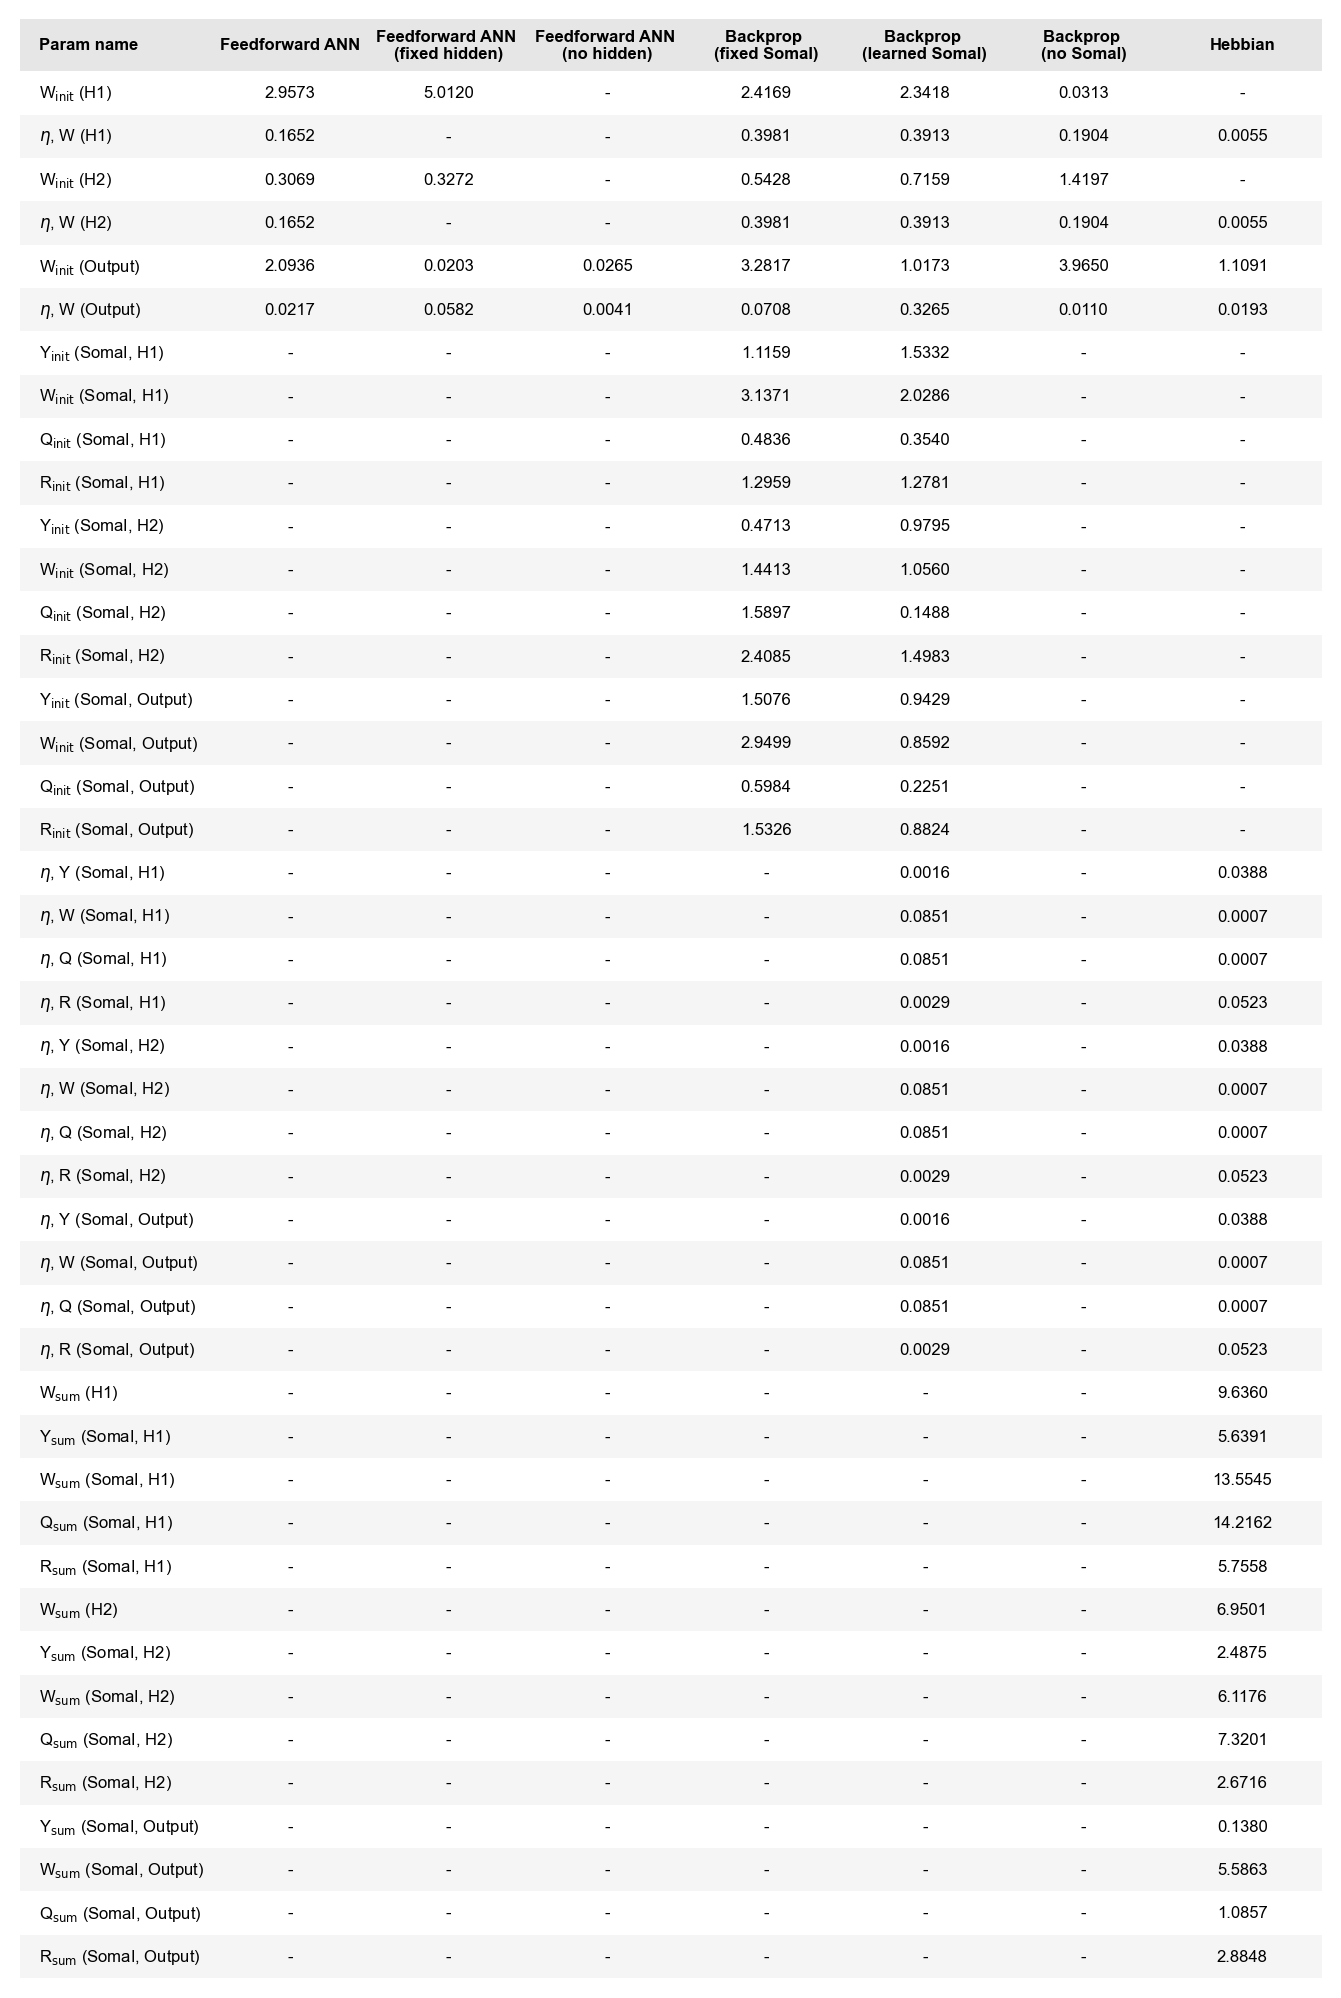

In [19]:
model_list = ["vanBP", "vanBP_fixed_hidden", "vanBP_0hidden",
                "bpDale_fixed", "bpDale_learned", "bpDale_noI", "HebbWN_topsup"]
filename = "FigT6_mnist_hyperparams_part1"

model_dict_all = load_model_dict()
generate_hyperparams_file(model_dict_all, model_list, filename=filename)
generate_hyperparams_table(filename)

Saved hyperparams table to /EIANN/EIANN/data/FigT6_mnist_hyperparams_part2.xlsx
Saved hyperparams table to /EIANN/EIANN/data/FigT6_mnist_hyperparams_part2.csv


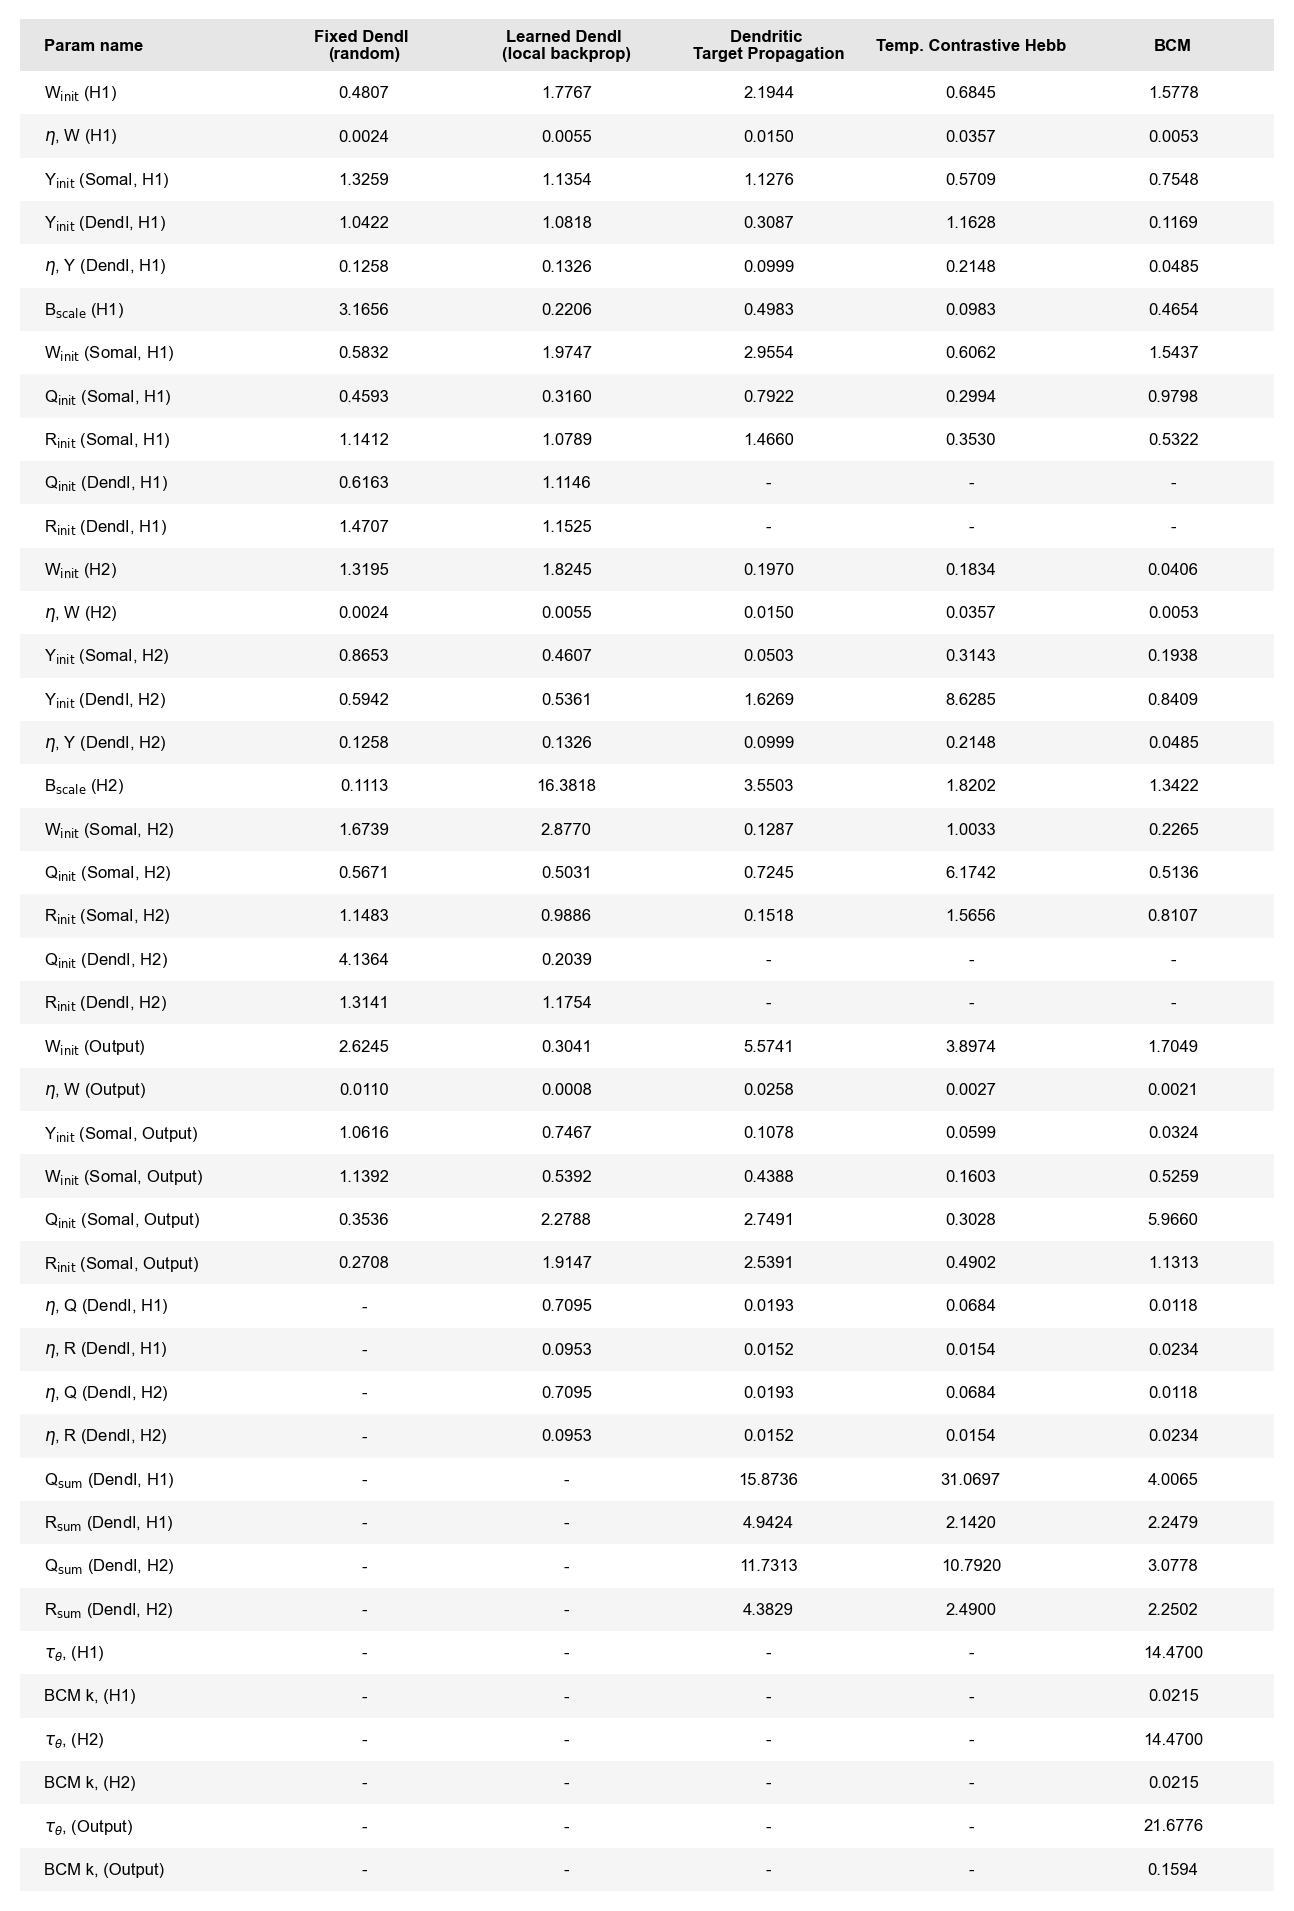

In [20]:
model_list = ["bpLike_WT_fixedDend", "bpLike_WT_localBP", "bpLike_WT_hebbdend", 
                "SupHebbTempCont_WT_hebbdend", "Supervised_BCM_WT_hebbdend"]
filename = "FigT6_mnist_hyperparams_part2"

model_dict_all = load_model_dict()
generate_hyperparams_file(model_dict_all, model_list, filename=filename)
generate_hyperparams_table(filename)

Saved hyperparams table to /EIANN/EIANN/data/FigT6_mnist_hyperparams_part3.xlsx
Saved hyperparams table to /EIANN/EIANN/data/FigT6_mnist_hyperparams_part3.csv


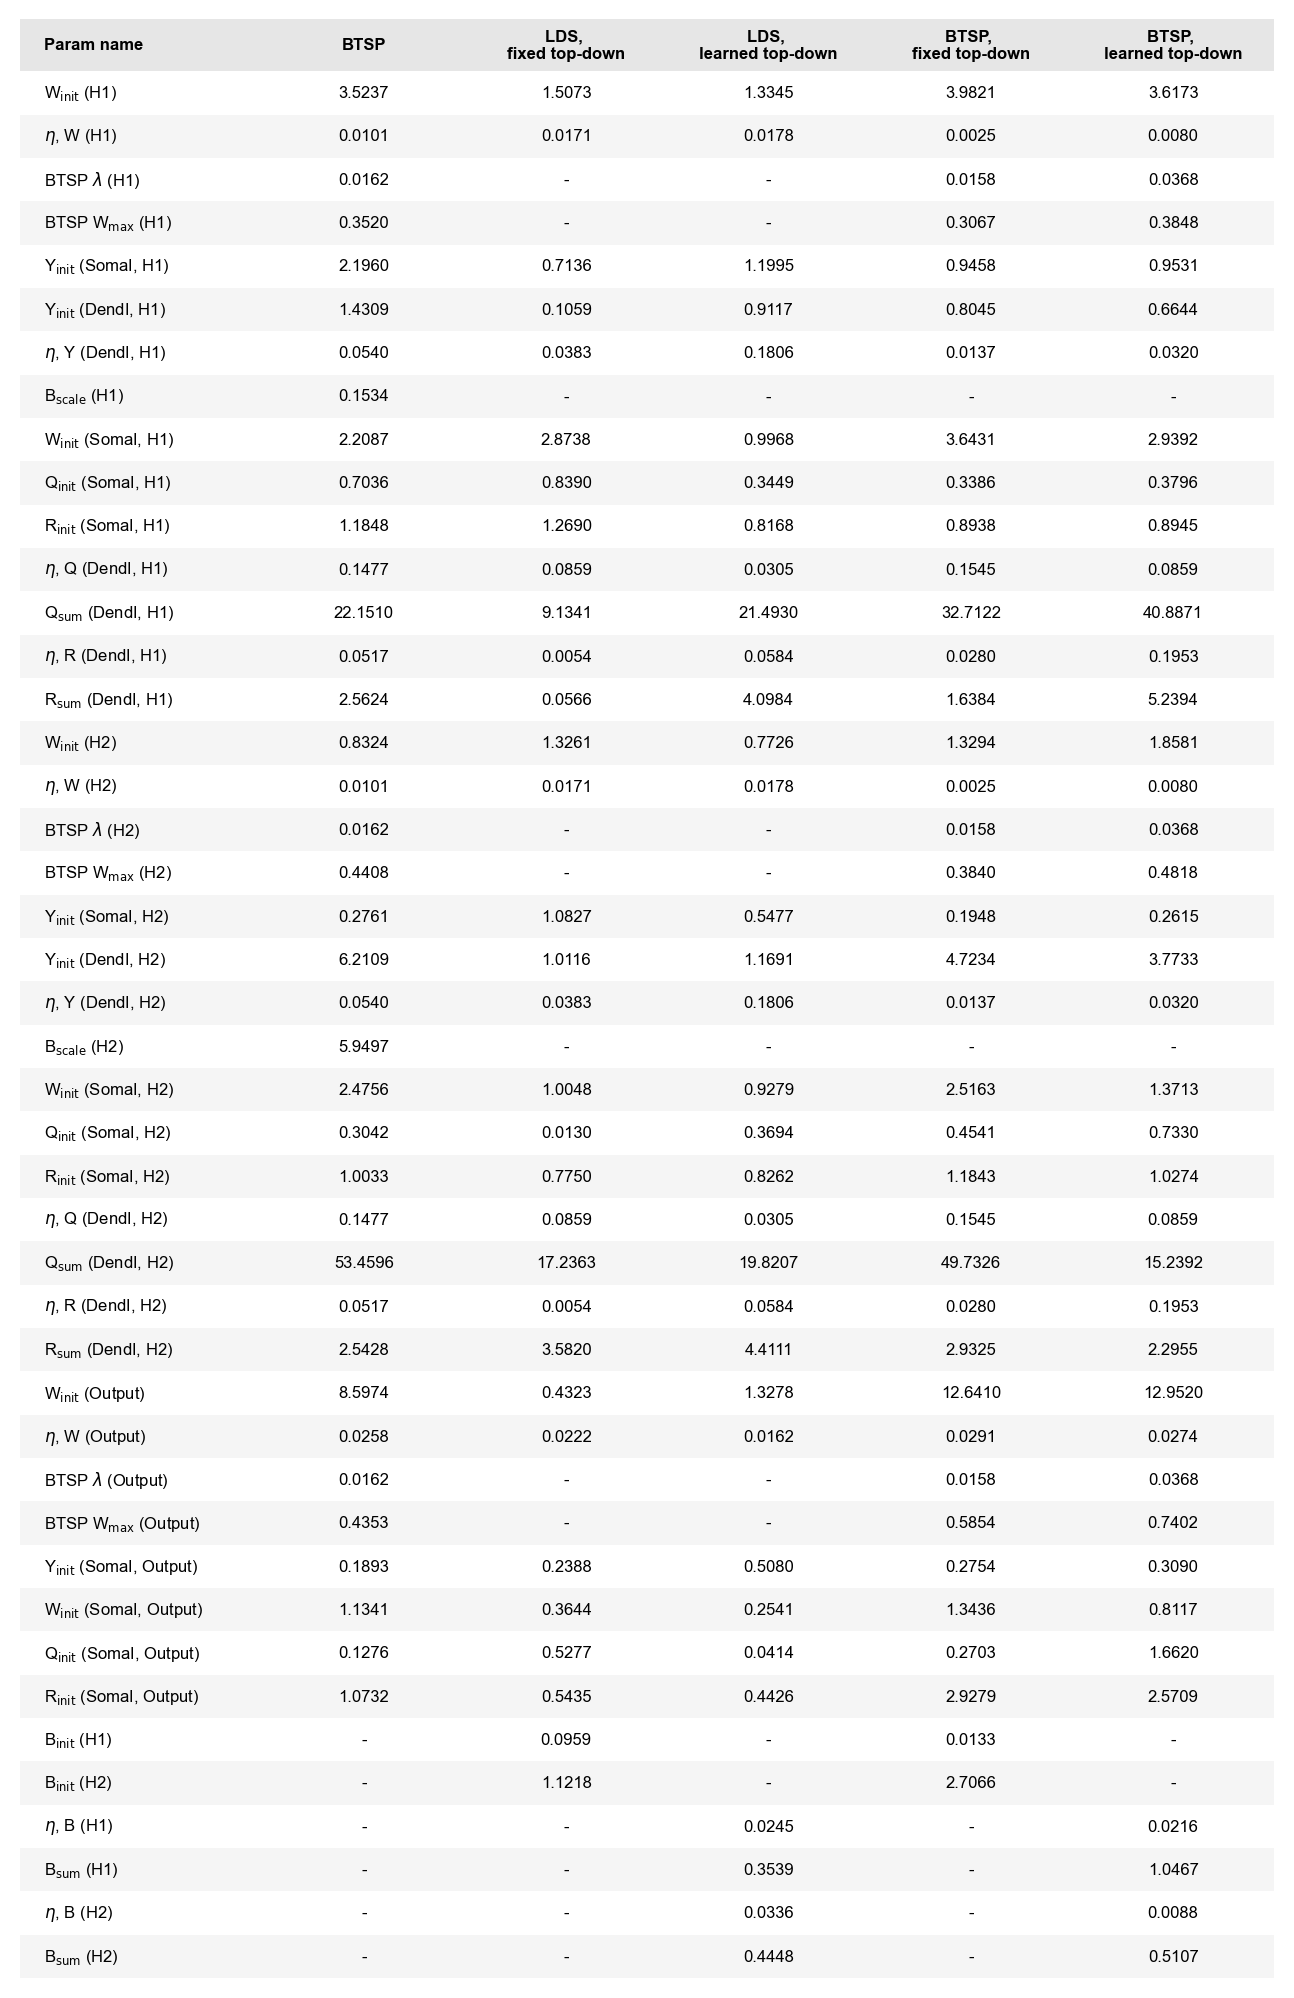

In [21]:
model_list = ["BTSP_WT_hebbdend", "bpLike_fixedTD_hebbdend", "bpLike_TCWN_hebbdend", "BTSP_fixedTD_hebbdend", "BTSP_TCWN_hebbdend"]
filename = "FigT6_mnist_hyperparams_part3"

model_dict_all = load_model_dict()
generate_hyperparams_file(model_dict_all, model_list, filename=filename)
generate_hyperparams_table(filename)

# Spirals Hyperparams

Saved hyperparams table to /EIANN/EIANN/data/FigT7_spiral_hyperparams.xlsx
Saved hyperparams table to /EIANN/EIANN/data/FigT7_spiral_hyperparams.csv


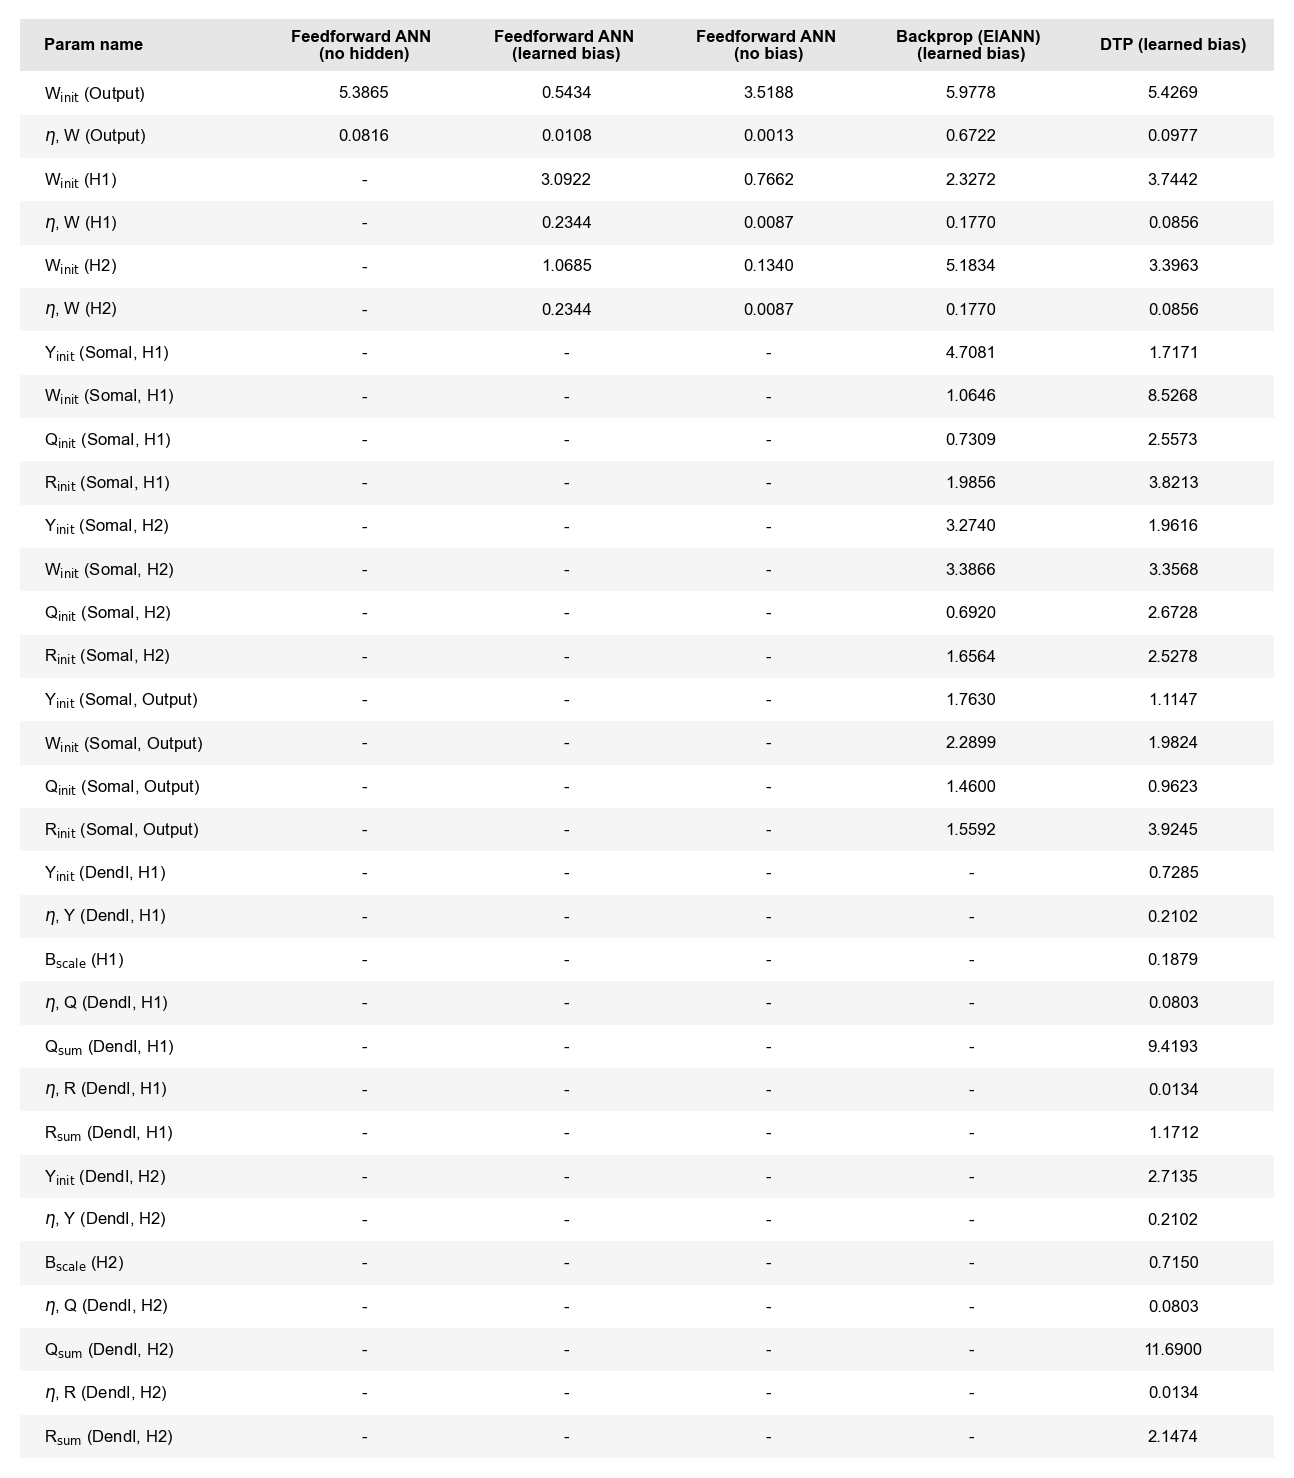

In [22]:
model_list = ["vanBP_0_hidden_learned_bias_spiral", "vanBP_2_hidden_learned_bias_spiral", 
            "vanBP_2_hidden_zero_bias_spiral", "bpDale_learned_bias_spiral", "DTP_learned_bias_spiral"]
filename = "FigT7_spiral_hyperparams"

model_dict_all = load_model_dict()
generate_hyperparams_file(model_dict_all, model_list, filename=filename)
generate_hyperparams_table(filename)

# FMNIST Hyperparams

Saved hyperparams table to /EIANN/EIANN/data/FigT8_fmnist_hyperparams.xlsx
Saved hyperparams table to /EIANN/EIANN/data/FigT8_fmnist_hyperparams.csv


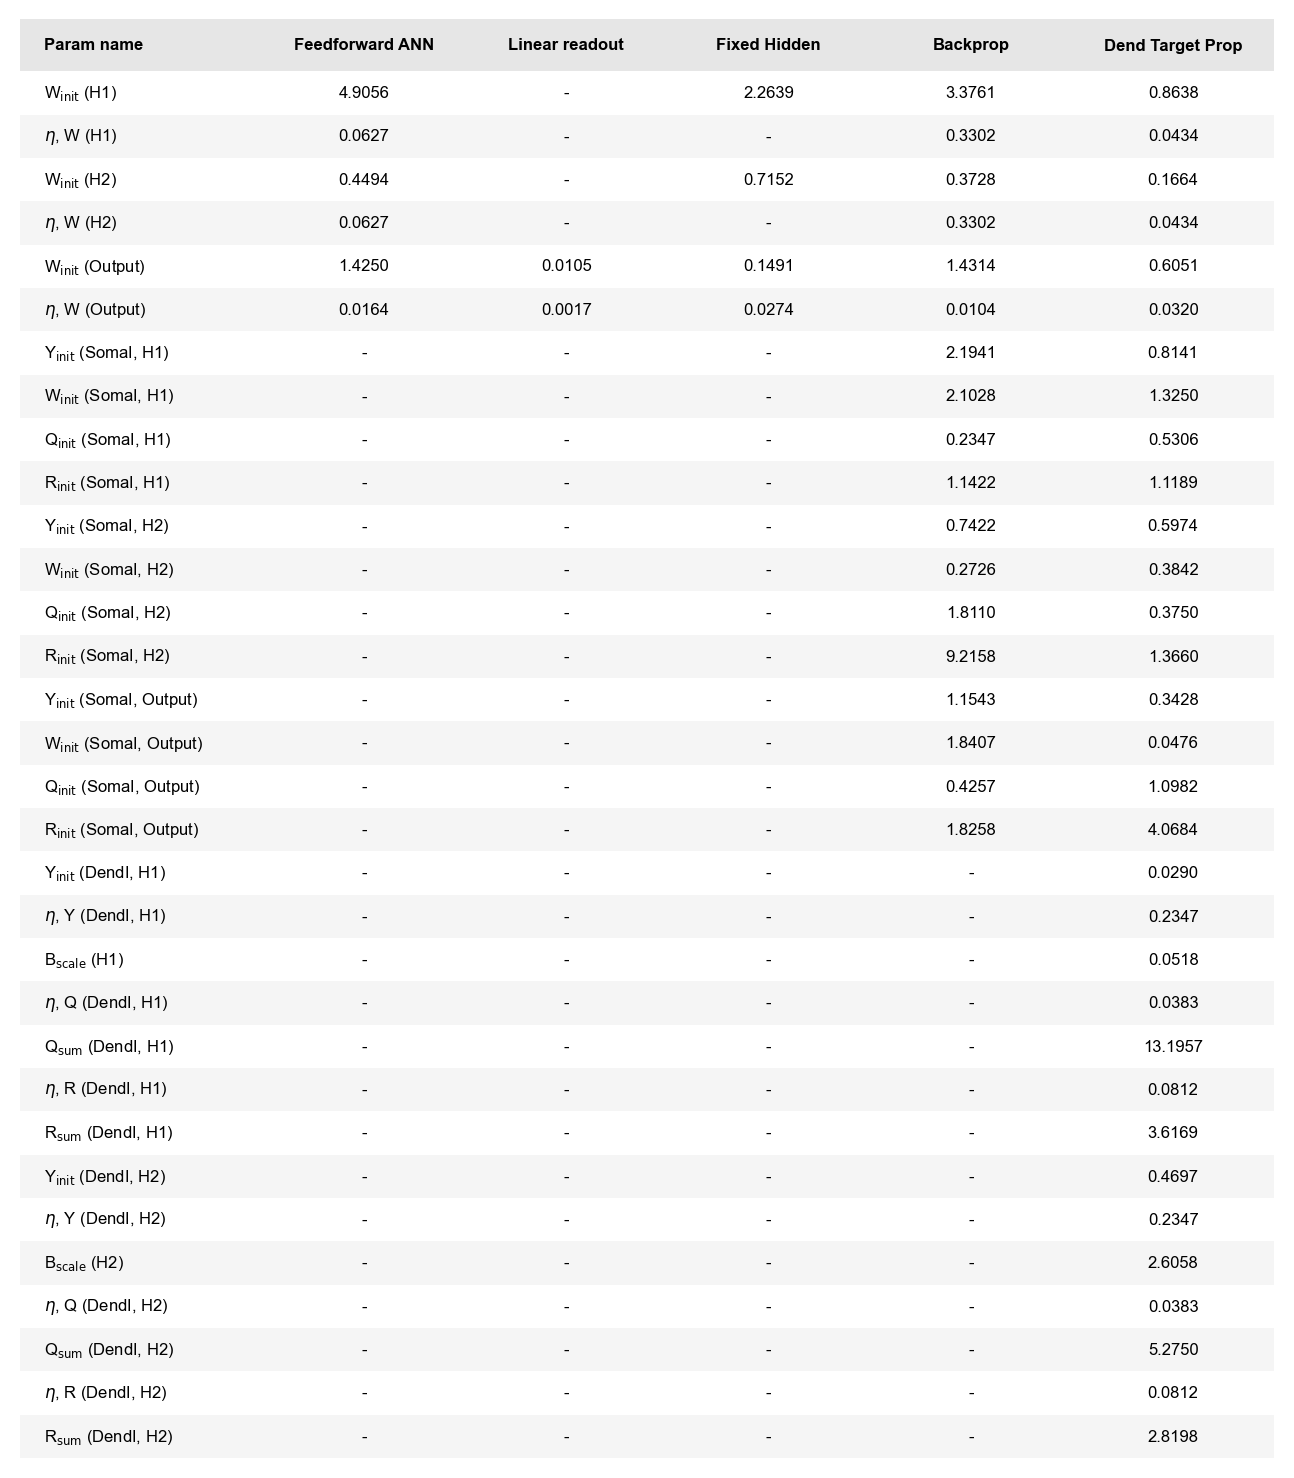

In [23]:
filename = "FigT8_fmnist_hyperparams"
model_list = ["fmnist_vanBP_nobias","fmnist_0hidden_vanBP_nobias", "fmnist_fixed_vanBP_nobias", "fmnist_bpDale_nobias", "fmnist_DTP_WT_hebbdend"]

model_dict_all = load_model_dict()
generate_hyperparams_file(model_dict_all, model_list, filename=filename)
generate_hyperparams_table(filename)

# CIFAR-10 Hyperparams

Saved hyperparams table to /EIANN/EIANN/data/FigT9_cifar10_hyperparams.xlsx
Saved hyperparams table to /EIANN/EIANN/data/FigT9_cifar10_hyperparams.csv


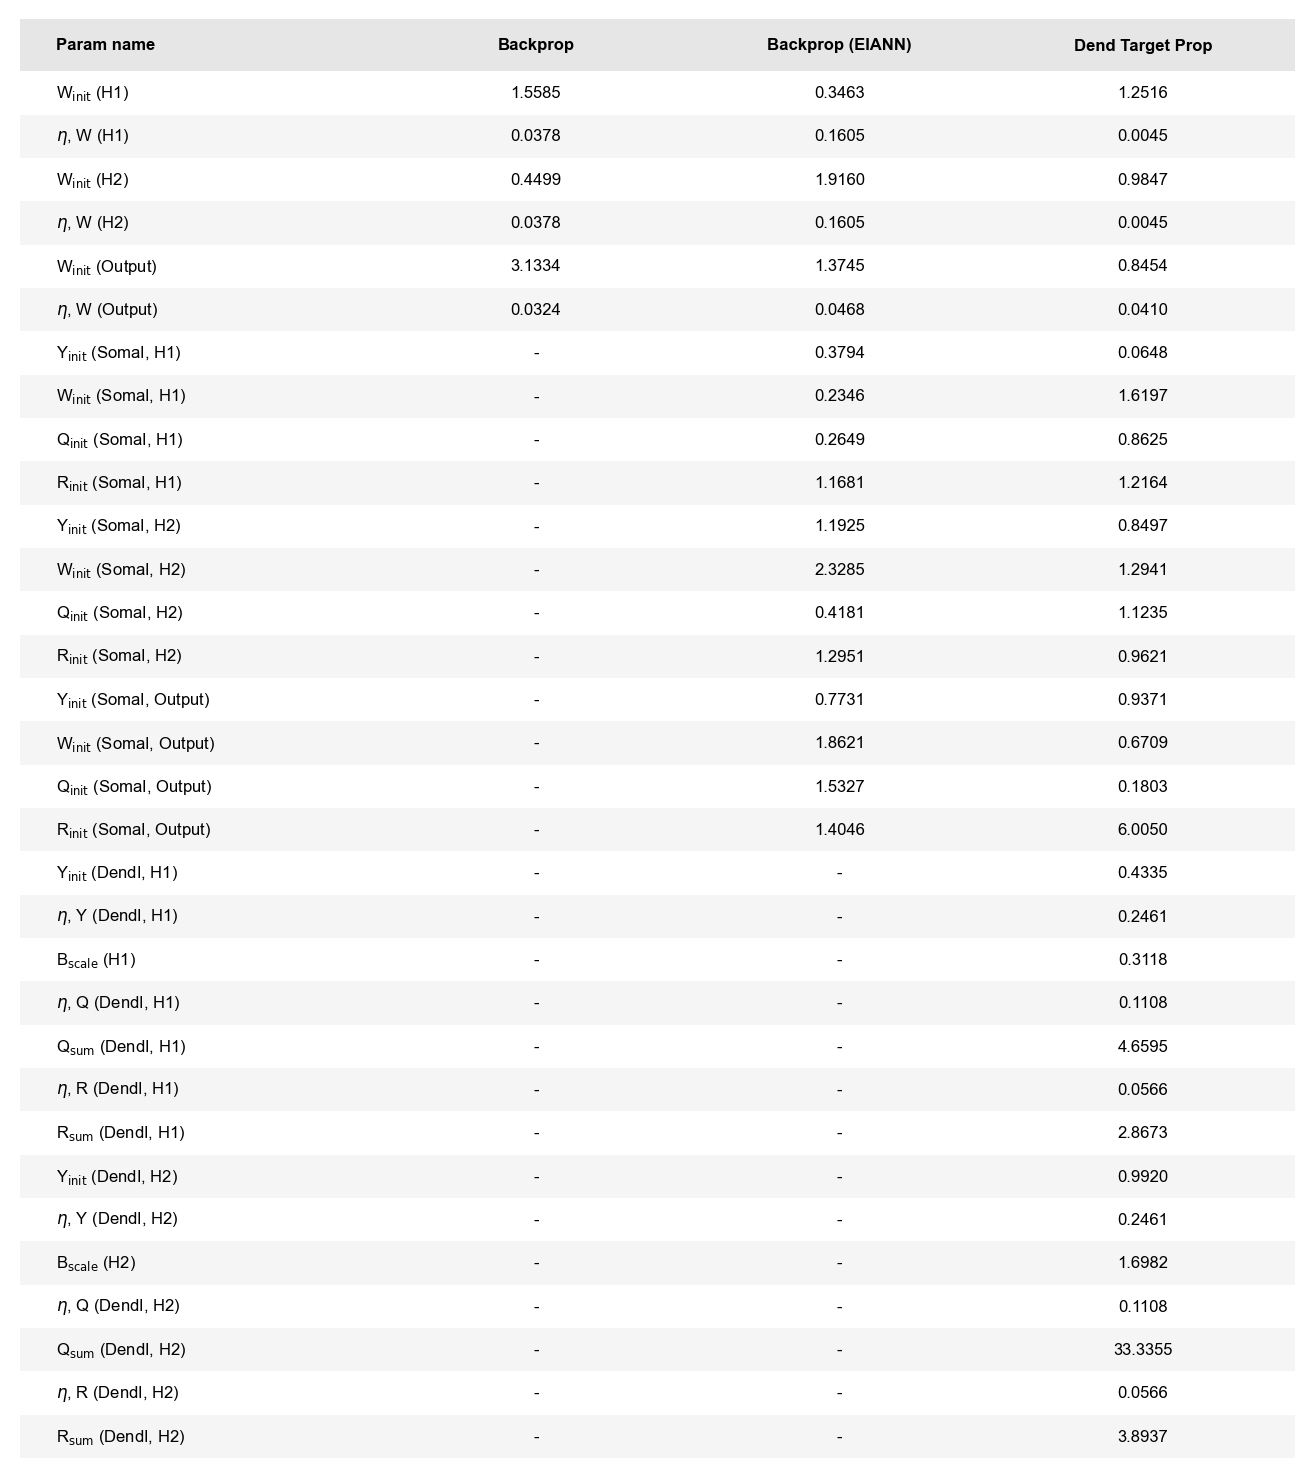

In [24]:
filename = "FigT9_cifar10_hyperparams"
model_list = ["vanBP_localrf_cifar", "bpDale_localrf_cifar", "DTP_localrf_cifar"]

model_dict_all = load_model_dict()
generate_hyperparams_file(model_dict_all, model_list, filename=filename)
generate_hyperparams_table(filename)